In [1]:
initial_path = 'peptide-QML/'
initial_path = '../'

In [2]:
day = "0803"
name_notebook = day + "-sq_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_angles(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

# X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
# X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X, dtype=ptm.torch.float64) 
target_data = ptm.torch.tensor(Y, dtype=ptm.torch.float64).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation, dtype=ptm.torch.float64)
target_validation = ptm.torch.tensor(Y_validation, dtype=ptm.torch.float64).view(-1, 1)

# Quantum node

In [8]:
n_aminoacids = len(string_list[0])

In [9]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    # embedding_ansatz = qn.parts.Ansatz_11,
    ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.exp_Z(1),
    n_layers = 50,
    # n_layers_embedding = 50,
    # n_layers_block = 50,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

AttributeError: type object 'parts' has no attribute 'exp_Z'

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

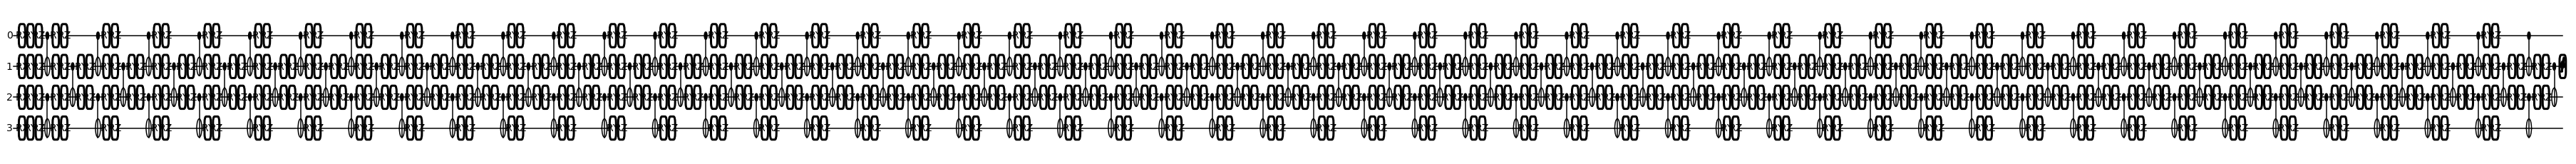

In [ ]:
quantum_layer.draw(size=(50,3))

# Quantum model

In [ ]:
layers = [quantum_layer()]

In [ ]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
    # keep_track_params=True,
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [ ]:
print(model(input_data[0]).item())
print(model(input_data[1]).item())

0.27874105582345643
0.237040480377891


In [ ]:
model.keep_track_params=True,

In [ ]:
import torch.optim as optim

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.5},
    num_epochs = 25,                
    batch_size = 32,
)

Epoch [0/25], Loss: 1.9888, Loss validation: 2.0861


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: 0.3068, 	 target: -0.0741, 	 loss: 5.1425
	 Validation string, 	 i: 1; 	 prediction: 0.2977, 	 target: -0.0990, 	 loss: 4.0058
	 Validation string, 	 i: 2; 	 prediction: 0.1914, 	 target: -0.0572, 	 loss: 4.3489
Epoch [1/25], Loss: 2.1561, Loss validation: 2.3282, Time remaining: ~0.0h 40.0m 7s
	 Validation string, 	 i: 0; 	 prediction: 0.2601, 	 target: -0.0741, 	 loss: 4.5121
	 Validation string, 	 i: 1; 	 prediction: -0.1131, 	 target: -0.0990, 	 loss: 0.1417
	 Validation string, 	 i: 2; 	 prediction: 0.3244, 	 target: -0.0572, 	 loss: 6.6768
Epoch [2/25], Loss: 2.1944, Loss validation: 2.0434, Time remaining: ~0.0h 36.0m 25s
	 Validation string, 	 i: 0; 	 prediction: -0.4145, 	 target: -0.0741, 	 loss: 4.5974
	 Validation string, 	 i: 1; 	 prediction: 0.1555, 	 target: -0.0990, 	 loss: 2.5703
	 Validation string, 	 i: 2; 	 prediction: 0.2449, 	 target: -0.0572, 	 loss: 5.2857
Epoch [3/25], Loss: 2.1906, Loss validation: 1.9555, Time remain

Saved in:  peptide-QML/checkpoints/0803/plots/0803-sq_1qm_parameter_0.weights_None_2.png


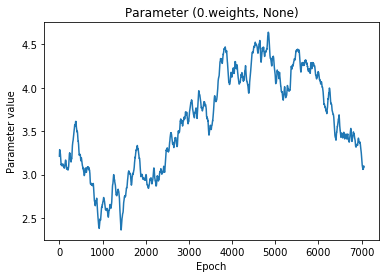

In [ ]:
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

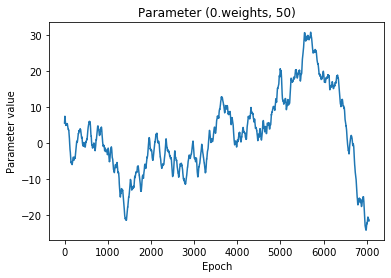

In [ ]:
model.plot_parameter(layer='0.weights', index=50)

Saved in:  peptide-QML/checkpoints/0803/plots/0803-sq_1qm_losses_batches_2.png


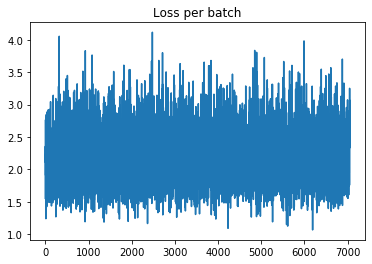

Saved in:  peptide-QML/checkpoints/0803/plots/0803-sq_1qm_losses_epoch_2.png


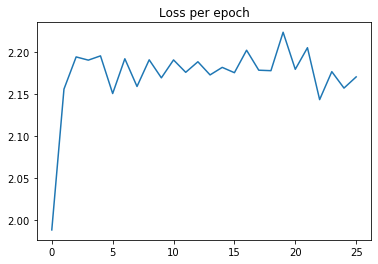

Saved in:  peptide-QML/checkpoints/0803/plots/0803-sq_1qm_losses_epoch_validation_2.png


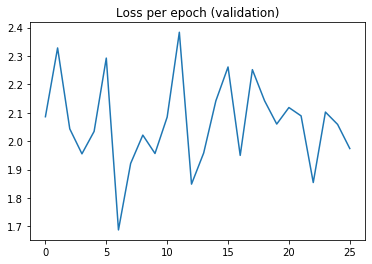

In [ ]:
# plot the losses of the trainig loop
model.plot_losses(save=True)

In [ ]:
model.save_state_dict()

Model saved as peptide-QML/checkpoints/0803/models/0803-sq_1qm_2.pth


In [ ]:
#load model
model.load_state_dict()

Model loaded from peptide-QML/checkpoints/0803/models/0803-sq_1qm_2.pth


In [ ]:
# print validation
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: -0.0741, 	 output: -0.1946, 	 loss: 1.6281
i: 1, 		 target: 0.0199, 	 output: -0.1401, 	 loss: 8.0415
i: 2, 		 target: -0.0480, 	 output: -0.0264, 	 loss: 0.4501
i: 3, 		 target: -0.0379, 	 output: -0.2957, 	 loss: 6.7945
i: 4, 		 target: -0.0528, 	 output: 0.3678, 	 loss: 7.9594
i: 5, 		 target: -0.0476, 	 output: -0.3149, 	 loss: 5.6160
i: 6, 		 target: -0.0008, 	 output: -0.0700, 	 loss: 81.9213
i: 7, 		 target: 0.1923, 	 output: 0.0558, 	 loss: 0.7099
i: 8, 		 target: 0.0136, 	 output: 0.3229, 	 loss: 22.8047
i: 9, 		 target: 0.2361, 	 output: -0.3710, 	 loss: 2.5712
i: 10, 		 target: -0.0990, 	 output: -0.0719, 	 loss: 0.2742
i: 11, 		 target: 0.0754, 	 output: -0.2882, 	 loss: 4.8203
i: 12, 		 target: 0.2029, 	 output: -0.0054, 	 loss: 1.0265
i: 13, 		 target: -0.0593, 	 output: -0.1377, 	 loss: 1.3208
i: 14, 		 target: -0.0780, 	 output: 0.0770, 	 loss: 1.9877
i: 15, 		 target: -0.0904, 	 output: -0.3303, 	 loss: 2.6524
i: 16, 		 target: -0.0893, 	 output: -0.32

In [ ]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main dc38ef2] data trained model
 1 file changed, 1002 insertions(+)
 create mode 100644 checkpoints/0803/txts/0803-sq_1qm_validation_2.txt
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 24 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 13.41 KiB | 2.23 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To github.com:raulconchello/peptide-QML.git
   4ca6e8e..dc38ef2  main -> main
